# Assignment 3
## 1: `git` in practice

Link to this repository: [astr8004_assign3](https://github.com/cyb0rb/astr8004_assign3)

## 2: Using ADQL to search for bright stars around the open cluster M67


In [1]:
import numpy as np
import matplotlib.colors as colors


In [ ]:
# from astroquery.gaia import Gaia

## 3: Radial metallicity relation in simulated data

In [2]:
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [3]:
# load and get data from file
datafile = "data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits"    
data = Table.read(datafile)
print(data.info)

# radius
radius = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

<Table length=511520>
name  dtype 
---- -------
   x float32
   y float32
   z float32
 A_O float64



In [4]:
# fit linear function to data
def linear(x, a, b):
    return a*x + b

params, pcov = curve_fit(linear, radius, data['A_O'])
uncertainty = np.sqrt(np.diag(pcov))

print(f"Slope: {params[0]:.6f} ± {uncertainty[0]:.6f}")
print(f"Intercept: {params[1]:.5f} ± {uncertainty[1]:.5f}")

fit_data = linear(radius, *params)
residuals = data["A_O"] - fit_data

Slope: -0.033250 ± 0.000018
Intercept: 9.12232 ± 0.00028


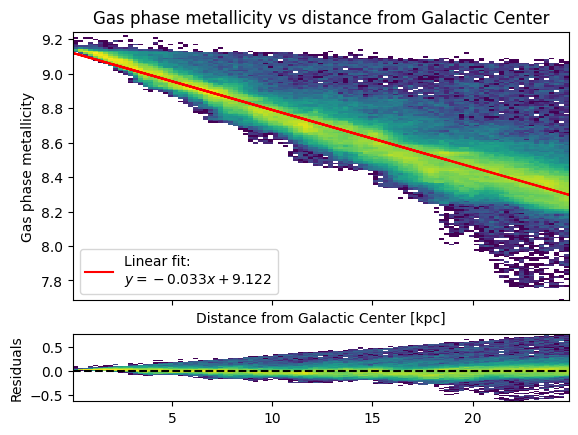

In [31]:
# plotting with a histogram instead

gridspec = {'height_ratios': [4,1]}
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=gridspec)

# radius vs metallicity
ax1.hist2d(
    radius, 
    data['A_O'], 
    bins=(np.arange(min(radius), max(radius), 0.25), np.arange(min(data['A_O']), max(data['A_O']), 0.01)),
    norm=colors.LogNorm()
    )
ax1.plot(
    radius, 
    fit_data, 
    "-r", 
    label=f"Linear fit:\n$y={params[0]:.3f}x + {params[1]:.3f}$"
    )

# residuals
ax2.hist2d(
    radius, 
    residuals, 
    bins=(np.arange(min(radius), max(radius), 0.25), np.arange(min(residuals), max(residuals), 0.01)),
    norm=colors.LogNorm()
    )
ax2.axhline(y=0, color="black", linestyle="--")

# labels
ax1.set(
    xlabel = "Distance from Galactic Center [kpc]",
    ylabel = "Gas phase metallicity",
    title  = "Gas phase metallicity vs distance from Galactic Center"
)
ax2.set(
    ylabel = "Residuals"
)
ax1.legend(loc="lower left")

# save
fig.savefig("figures/metallicity_histogram.png")
plt.show()

### Discussion here
the linear model fits best at closer distances (<10 kpc or so), and beyond that it underestimates the metallicity.

In [50]:
from scipy.stats import binned_statistic_2d

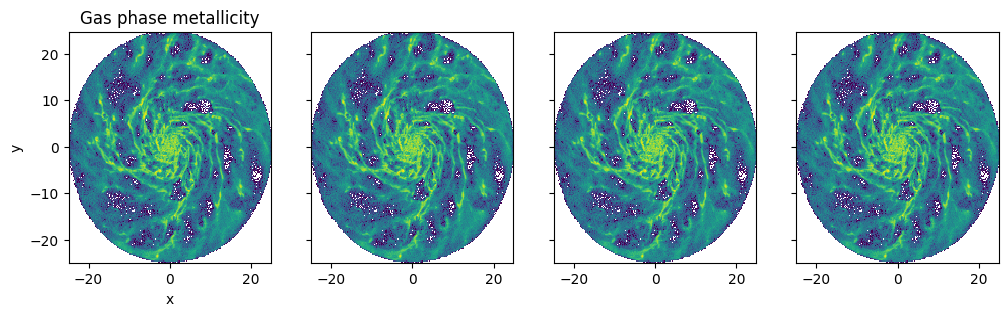

In [49]:
# plotting with a histogram instead

# gridspec = {'height_ratios': [4,1]}
fig, axs = plt.subplots(1,4, sharey=True, figsize=(12,3))

# radius vs metallicity
axs[0].hist2d(
    data['x'], 
    data['y'], 
    bins=(np.arange(min(data['x']), max(data['x']), 0.25), np.arange(min(data['y']), max(data['y']), 0.25)),
    norm=colors.LogNorm()
    )

axs[1].hist2d(
    data['x'], 
    data['y'], 
    bins=(np.arange(min(data['x']), max(data['x']), 0.25), np.arange(min(data['y']), max(data['y']), 0.25)),
    norm=colors.LogNorm()
    )

axs[2].hist2d(
    data['x'], 
    data['y'], 
    bins=(np.arange(min(data['x']), max(data['x']), 0.25), np.arange(min(data['y']), max(data['y']), 0.25)),
    norm=colors.LogNorm()
    )

axs[3].hist2d(
    data['x'], 
    data['y'], 
    bins=(np.arange(min(data['x']), max(data['x']), 0.25), np.arange(min(data['y']), max(data['y']), 0.25)),
    norm=colors.LogNorm()
    )

# labels
axs[0].set(
    xlabel = "x",
    ylabel = "y",
    title  = "Gas phase metallicity"
)

# save
fig.savefig("figures/metallicity_xy.png")
plt.show()